> > > > START > > > >
DATA: True | TRAIN_IMG: True | TEST_IMG: True
TRAIN_CSV: True | SAMPLE_SUB: True
('labels shape:', (220025, 2))
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


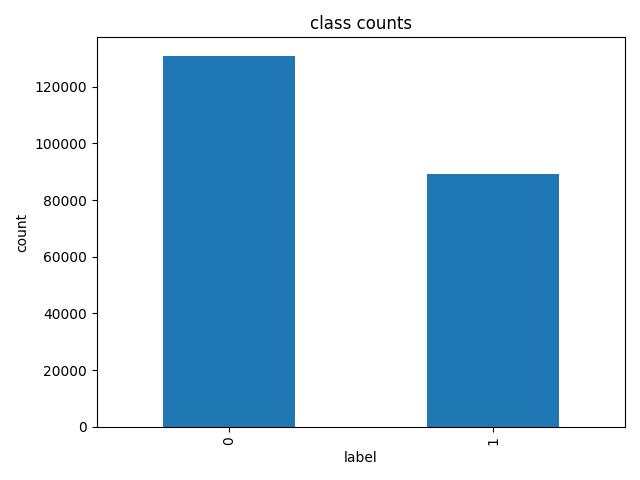

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]

device=cpu | train=2000 | val=500


('smoke batch:', (32, 3, 64, 64), (32,))
epoch 1 step 50/63
epoch 1 loss 0.5780 | val_auc 0.8911
new best auc 0.8911 saved to /kaggle/working/best_resnet18.pt
epoch 2 step 50/63
epoch 2 loss 0.4008 | val_auc 0.9001
new best auc 0.9001 saved to /kaggle/working/best_resnet18.pt
reloaded best model (AUC 0.9001)


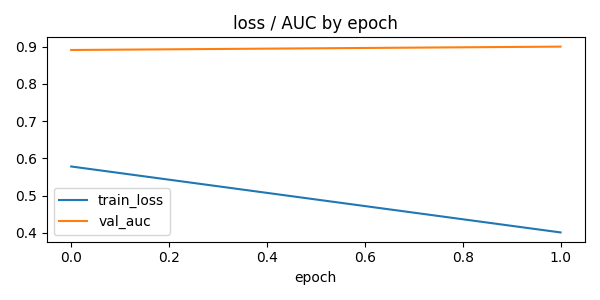

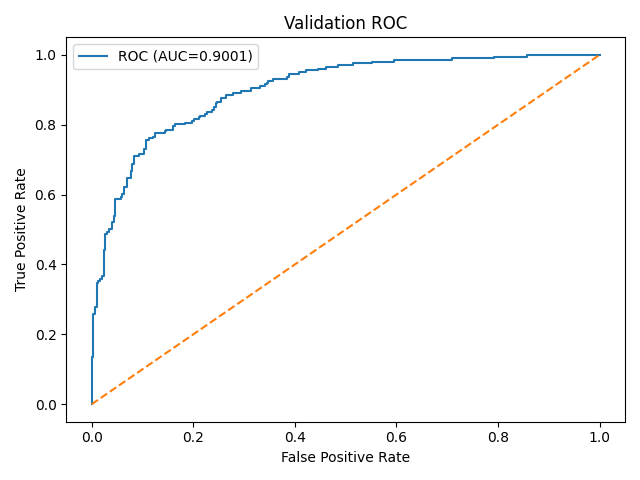

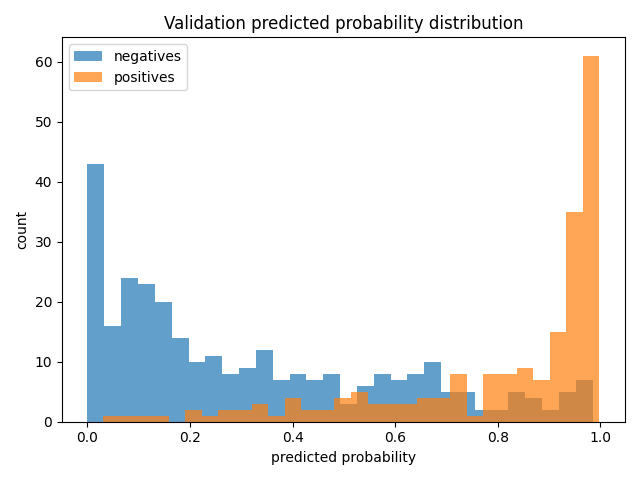

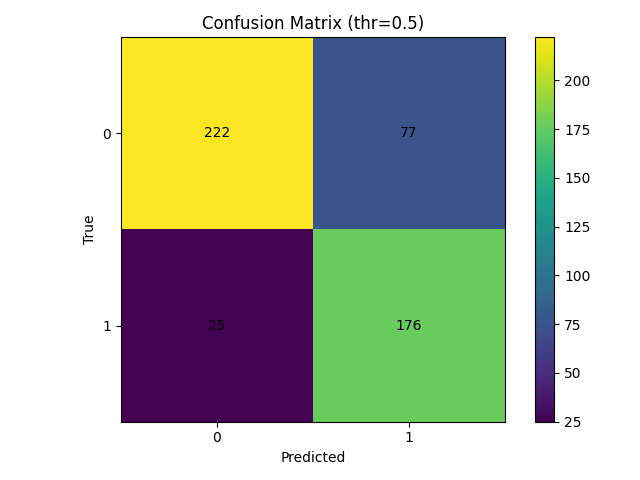

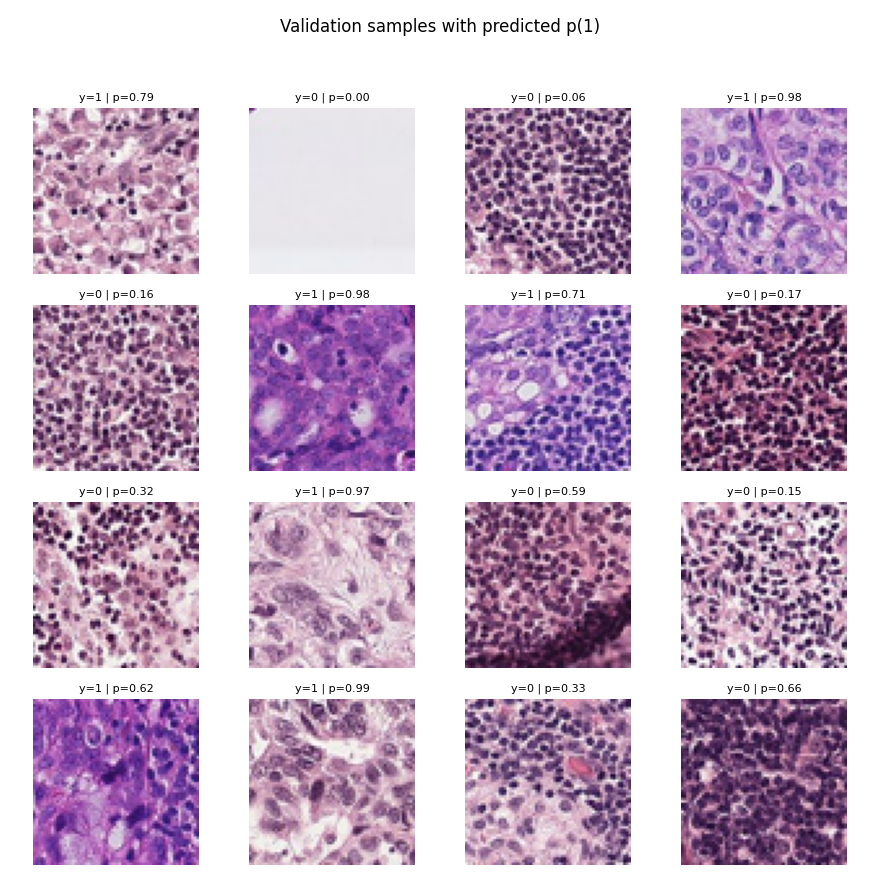

saved submission: /kaggle/working/submission.csv
log file: /kaggle/working/run.log
=== Mini-Project Conclusions ===
Val size: 500 (neg=299, pos=201)
Best AUC: 0.9001
Final — AUC 0.9001 | Acc 0.7960 | Prec 0.6957 | Rec 0.8756 | F1 0.7753
Notes:
- ResNet-18 @64x64 on a small subset is fast but not optimal.
- Threshold tuning may improve precision/recall.
- Use larger images/more data/epochs/aug to improve.
- Consider class weighting or oversampling if imbalanced.
done. best AUC (val subset): 0.9001 | curves: /kaggle/working/training_curves.png


In [ ]:

print("> > > > START > > > >", flush=True)

# Backend
import matplotlib
matplotlib.use("Agg")

# Imports
import os, random
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    precision_recall_fscore_support, accuracy_score
)



# Helper
from IPython.display import Image as _IPImage, display as _display
def _show_png(p):
    p = Path(p)
    if p.exists():
        _display(_IPImage(filename=str(p)))
    else:
        print(f"[warn] missing: {p}", flush=True)



# TorchVision Compatibility
try:
    _ = models.ResNet18_Weights.IMAGENET1K_V1
    def make_resnet18():
        return models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
except AttributeError:
    def make_resnet18():
        return models.resnet18(pretrained=True)



# Logger
LOGFILE = Path("/kaggle/working/run.log")
def log(msg):
    print(msg, flush=True)
    with open(LOGFILE, "a", encoding="utf-8") as f:
        f.write(str(msg) + "\n")



# Seed
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)



# Paths
DATA = Path("/kaggle/input/histopathologic-cancer-detection")
TRAIN_IMG = DATA/"train"
TRAIN_CSV = DATA/"train_labels.csv"
TEST_IMG  = DATA/"test"
WORK = Path("/kaggle/working")
SAMPLE_SUB = DATA/"sample_submission.csv"
IMG_EXT = "tif"



# Quick Check
if not (DATA.exists() and TRAIN_IMG.exists() and TRAIN_CSV.exists()):
    log("DATA NOT FOUND — attach 'Histopathologic Cancer Detection'")
    raise SystemExit(1)
log(f"DATA: {DATA.exists()} | TRAIN_IMG: {TRAIN_IMG.exists()} | TEST_IMG: {TEST_IMG.exists()}")
log(f"TRAIN_CSV: {TRAIN_CSV.exists()} | SAMPLE_SUB: {SAMPLE_SUB.exists()}")



# Load Labels
df = pd.read_csv(TRAIN_CSV)
log(("labels shape:", df.shape))
log(df.head())



# EDA
plt.figure()
df["label"].value_counts().plot(kind="bar", title="class counts")
plt.xlabel("label"); plt.ylabel("count")
plt.tight_layout(); plt.savefig(WORK/"class_counts.png"); plt.show()
_show_png(WORK/"class_counts.png")



# Split
tr_df, va_df = train_test_split(df, test_size=0.1, stratify=df.label, random_state=42)
tr_df = tr_df.sample(2000, random_state=0)
va_df = va_df.sample(500,  random_state=0)



# Transforms
IMG_SIZE = 64
t_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
t_val = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])



# Dataset
class HistoDS(Dataset):
    def __init__(self, df, folder, tfm, with_label=True):
        self.df = df.reset_index(drop=True)
        self.folder = folder
        self.tfm = tfm
        self.with_label = with_label
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        rid = self.df.loc[i, "id"]
        img = Image.open(self.folder/f"{rid}.{IMG_EXT}").convert("RGB")
        x = self.tfm(img)
        if self.with_label:
            y = torch.tensor(self.df.loc[i, "label"], dtype=torch.float32)
            return x, y
        return x, rid



# Loaders
train_dl = DataLoader(HistoDS(tr_df, TRAIN_IMG, t_train, True), batch_size=32, shuffle=True, num_workers=0)
val_dl   = DataLoader(HistoDS(va_df, TRAIN_IMG, t_val,   True), batch_size=64, shuffle=False, num_workers=0)



# Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = make_resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
log(f"device={device} | train={len(tr_df)} | val={len(va_df)}")



# Smoke Batch
xb, yb = next(iter(train_dl))
log(("smoke batch:", tuple(xb.shape), tuple(yb.shape)))



# Validation Helpers
def val_preds():
    model.eval()
    ys, ps = [], []
    with torch.inference_mode():
        for xb, yb in val_dl:
            xb = xb.to(device)
            p = torch.sigmoid(model(xb)).squeeze(1).cpu().numpy()
            ys.append(yb.numpy()); ps.append(p)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    return ys, ps

def val_auc():
    ys, ps = val_preds()
    return roc_auc_score(ys, ps)



# Train
EPOCHS = 2
best_auc, best_path = 0.0, WORK/"best_resnet18.pt"
train_losses, val_aucs = [], []
for e in range(EPOCHS):
    model.train()
    run_loss = 0.0
    for i, (xb, yb) in enumerate(train_dl, 1):
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb).squeeze(1)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        run_loss += loss.item()
        if i % 50 == 0:
            log(f"epoch {e+1} step {i}/{len(train_dl)}")
    avg_loss = run_loss / max(1, len(train_dl))
    auc = val_auc()
    train_losses.append(avg_loss); val_aucs.append(auc)
    log(f"epoch {e+1} loss {avg_loss:.4f} | val_auc {auc:.4f}")
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), best_path)
        log(f"new best auc {best_auc:.4f} saved to {best_path}")



# Reload Best
if best_path.exists():
    model.load_state_dict(torch.load(best_path, map_location=device))
    log(f"reloaded best model (AUC {best_auc:.4f})")



# Plots: Curves
plt.figure(figsize=(6,3))
plt.plot(train_losses, label="train_loss")
plt.plot(val_aucs, label="val_auc")
plt.title("loss / AUC by epoch")
plt.xlabel("epoch"); plt.legend(); plt.tight_layout()
plt.savefig(WORK/"training_curves.png"); plt.show()
_show_png(WORK/"training_curves.png")



# Plots: ROC
ys_val, ps_val = val_preds()
fpr, tpr, thr = roc_curve(ys_val, ps_val)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(ys_val, ps_val):.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Validation ROC")
plt.legend(); plt.tight_layout()
plt.savefig(WORK/"val_roc.png"); plt.show()
_show_png(WORK/"val_roc.png")



# Plots: Probability Histogram
plt.figure()
plt.hist(ps_val[ys_val==0], bins=30, alpha=0.7, label="negatives")
plt.hist(ps_val[ys_val==1], bins=30, alpha=0.7, label="positives")
plt.xlabel("predicted probability"); plt.ylabel("count")
plt.title("Validation predicted probability distribution")
plt.legend(); plt.tight_layout()
plt.savefig(WORK/"val_pred_hist.png"); plt.show()
_show_png(WORK/"val_pred_hist.png")



# Plots: Confusion Matrix
yhat_val = (ps_val >= 0.5).astype(int)
cm = confusion_matrix(ys_val, yhat_val, labels=[0,1])
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (thr=0.5)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0","1"])
plt.yticks(tick_marks, ["0","1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(WORK/"val_confusion_matrix.png"); plt.show()
_show_png(WORK/"val_confusion_matrix.png")



# Plots: Sample Tiles
def show_val_samples(n=16):
    ids = va_df["id"].values[:n]
    lbls = va_df["label"].values[:n]
    imgs = []
    probs = []
    model.eval()
    with torch.inference_mode():
        for rid in ids:
            img = Image.open(TRAIN_IMG/f"{rid}.{IMG_EXT}").convert("RGB")
            x = t_val(img).unsqueeze(0).to(device)
            p = torch.sigmoid(model(x)).item()
            imgs.append(img.resize((IMG_SIZE, IMG_SIZE)))
            probs.append(p)
    cols = int(np.sqrt(n)); rows = int(np.ceil(n/cols))
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i,(im, p, y) in enumerate(zip(imgs, probs, lbls)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(im)
        ax.axis("off")
        ax.set_title(f"y={int(y)} | p={p:.2f}", fontsize=8)
    plt.suptitle("Validation samples with predicted p(1)")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(WORK/"val_samples_grid.png"); plt.show()

show_val_samples(16)
_show_png(WORK/"val_samples_grid.png")



# Submit
sub = pd.read_csv(SAMPLE_SUB)
test_ds = HistoDS(sub[["id"]], TEST_IMG, t_val, with_label=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)
model.eval()
pred = []
with torch.inference_mode():
    for xb, _ids in test_dl:
        xb = xb.to(device)
        p = torch.sigmoid(model(xb)).squeeze(1).cpu().numpy()
        pred.extend(p)
sub["label"] = pred
out_path = WORK/"submission.csv"
sub.to_csv(out_path, index=False)
log(f"saved submission: {out_path}")
log(f"log file: {LOGFILE}")



# Conclusion
acc  = accuracy_score(ys_val, yhat_val)
prec, rec, f1, _ = precision_recall_fscore_support(ys_val, yhat_val, average="binary", zero_division=0)
neg, pos = (ys_val == 0).sum(), (ys_val == 1).sum()
print(
    "=== Mini-Project Conclusions ===\n"
    f"Val size: {len(ys_val)} (neg={neg}, pos={pos})\n"
    f"Best AUC: {best_auc:.4f}\n"
    f"Final — AUC {roc_auc_score(ys_val, ps_val):.4f} | "
    f"Acc {acc:.4f} | Prec {prec:.4f} | Rec {rec:.4f} | F1 {f1:.4f}\n"
    "Notes:\n"
    "- ResNet-18 @64x64 on a small subset is fast but not optimal.\n"
    "- Threshold tuning may improve precision/recall.\n"
    "- Use larger images/more data/epochs/aug to improve.\n"
    "- Consider class weighting or oversampling if imbalanced."
)
print(f"done. best AUC (val subset): {best_auc:.4f} | curves: /kaggle/working/training_curves.png")
